# Torch tutorial
- source: https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

In [1]:
# problems with torch and torchvision
# -- https://discuss.pytorch.org/t/failed-to-load-image-python-extension-could-not-find-module/140278/14 

# pip install --upgrade torch==1.9.0
# pip install --upgrade torchvision==0.10.0

In [14]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

from matplotlib import pyplot as plt
import sys
import platform


In [16]:
print("Platform", platform.system(), platform.release())
print("Python version",sys.version)

print("torch",torch.__version__)
print("torchvision",torchvision.__version__)

Platform Darwin 22.3.0
Python version 3.8.12 (default, Jul 12 2022, 16:17:42) 
[Clang 13.1.6 (clang-1316.0.21.2.5)]
torch 1.13.1
torchvision 0.14.1


In [4]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

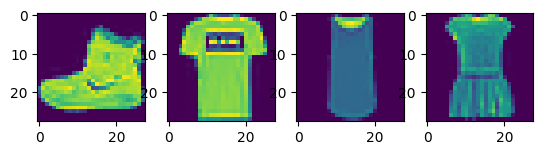

In [5]:
n = 4
fig,ax = plt.subplots(1,n)
for i in range(n):
    ax[i].imshow(training_data.data[i])
    

In [6]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [10]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [12]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
            
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [13]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.312347  [   64/60000]
loss: 2.302247  [ 6464/60000]
loss: 2.281128  [12864/60000]
loss: 2.273672  [19264/60000]
loss: 2.255367  [25664/60000]
loss: 2.221301  [32064/60000]
loss: 2.225967  [38464/60000]
loss: 2.191056  [44864/60000]
loss: 2.188787  [51264/60000]
loss: 2.153403  [57664/60000]
Test Error: 
 Accuracy: 51.7%, Avg loss: 2.152133 

Epoch 2
-------------------------------
loss: 2.164601  [   64/60000]
loss: 2.155399  [ 6464/60000]
loss: 2.093837  [12864/60000]
loss: 2.109811  [19264/60000]
loss: 2.063709  [25664/60000]
loss: 2.000663  [32064/60000]
loss: 2.018501  [38464/60000]
loss: 1.940927  [44864/60000]
loss: 1.942152  [51264/60000]
loss: 1.869451  [57664/60000]
Test Error: 
 Accuracy: 56.3%, Avg loss: 1.871187 

Epoch 3
-------------------------------
loss: 1.907314  [   64/60000]
loss: 1.878001  [ 6464/60000]
loss: 1.753897  [12864/60000]
loss: 1.795067  [19264/60000]
loss: 1.699092  [25664/60000]
loss: 1.647730  [32064/600

In [14]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [15]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

Predicted: "Ankle boot", Actual: "Ankle boot"
Predicted: "Pullover", Actual: "Pullover"
Predicted: "Trouser", Actual: "Trouser"
Predicted: "Trouser", Actual: "Trouser"
Predicted: "Pullover", Actual: "Shirt"
Predicted: "Trouser", Actual: "Trouser"
Predicted: "Coat", Actual: "Coat"
Predicted: "Coat", Actual: "Shirt"
Predicted: "Sneaker", Actual: "Sandal"
Predicted: "Sneaker", Actual: "Sneaker"


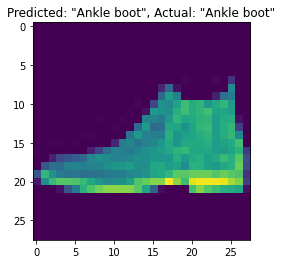

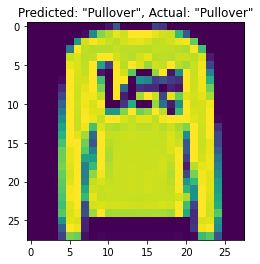

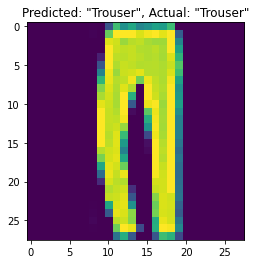

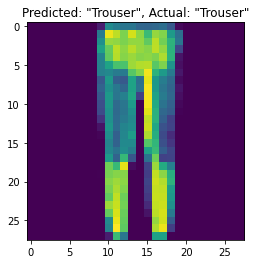

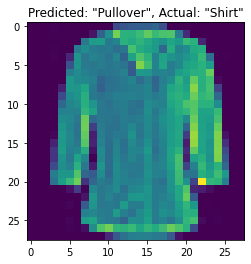

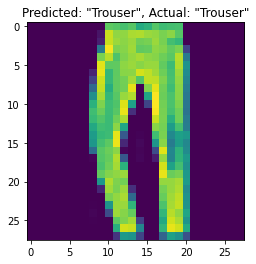

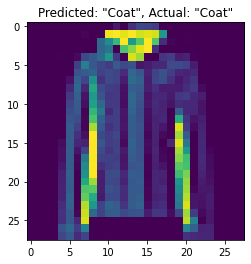

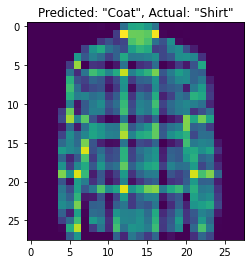

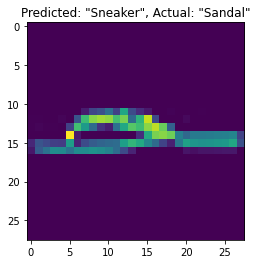

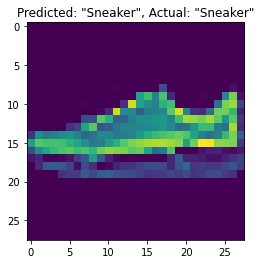

In [16]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()

n = 10
for i in range(n):
    x, y = test_data[i][0], test_data[i][1]
    with torch.no_grad():
        pred = model(x)
        predicted, actual = classes[pred[0].argmax(0)], classes[y]
        print(f'Predicted: "{predicted}", Actual: "{actual}"')
        plt.figure()
        plt.imshow(test_data.data[i])
        plt.title(f'Predicted: "{predicted}", Actual: "{actual}"')